## **Preprocessing of Train Data**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### **Clinical Data**

In [ ]:
clinical_train=pd.read_csv("/content/drive/My Drive/x_train/features/clinical_data_train.csv", index_col='PatientID')
clinical_train.head(5)

,Histology,Mstage,Nstage,SourceDataset,Tstage,age
PatientID,,,,,,
202,Adenocarcinoma,0,0,l2,2,66.0000
371,large cell,0,2,l1,4,64.5722
246,squamous cell carcinoma,0,3,l1,2,66.0452
240,nos,0,2,l1,3,59.3566
284,squamous cell carcinoma,0,3,l1,4,71.0554


In [ ]:
clinical_train.describe()

,Mstage,Nstage,Tstage,age
count,300.000000,300.000000,300.000000,284.000000
mean,0.040000,0.963333,2.103333,68.766856
std,0.314212,1.160378,1.072297,9.587605
min,0.000000,0.000000,1.000000,42.513300
25%,0.000000,0.000000,1.000000,62.979625
50%,0.000000,0.000000,2.000000,69.947300
75%,0.000000,2.000000,3.000000,76.201950
max,3.000000,3.000000,5.000000,87.126600


Variable "age" has 26 missing values.

In [ ]:
clinical_train.Mstage.value_counts(sort=False, dropna=False)

0    294
1      3
3      3
Name: Mstage, dtype: int64

Only 6 subjects have a different value to "0" for Mstage. This variable will not be used in the Cox models because there is almost no variation (=constant) and may cause convergence issue.

In [ ]:
clinical_train.Nstage.value_counts(sort=False, dropna=False)

0    167
1     17
2     76
3     40
Name: Nstage, dtype: int64

In [ ]:
clinical_train.Tstage.value_counts(sort=False, dropna=False)

1    105
2    111
3     33
4     50
5      1
Name: Tstage, dtype: int64

There is only one patient with Tstage="5". 
This patient is grouped with patients Tstage="4"

In [ ]:
clinical_train['Tstage']=clinical_train.Tstage.apply(lambda x: 4 if x==5 else x)

In [ ]:
clinical_train.Histology.value_counts(sort=False, dropna=False)

NaN                                    20
NSCLC NOS (not otherwise specified)     2
squamous cell carcinoma                59
adenocarcinoma                         21
Squamous cell carcinoma                19
large cell                             61
nos                                    38
Adenocarcinoma                         80
Name: Histology, dtype: int64

Similar histologies but named differently are grouped together in a new variable.

In [ ]:
clinical_train['Histology_cat']=clinical_train.Histology.apply(lambda x: 0 if x in ('Adenocarcinoma','adenocarcinoma') 
                                                               else 1 if x=='large cell' 
                                                               else 2 if x in('squamous cell carcinoma', 'Squamous cell carcinoma') 
                                                               else 3)

#Missing values and not specified histologies (NOS) are grouped together.

In [ ]:
clinical_train.Histology_cat.value_counts(sort=False, dropna=False)

0    101
1     61
2     78
3     60
Name: Histology_cat, dtype: int64

Dummification of categorical variables: Tstage, Nstage and Histology_cat

In [ ]:
#Mstage and Histology variables which will not be used in the survival analysis are removed.
clinical_train=clinical_train.drop(columns=["Mstage", "Histology"])

categories = ['Nstage', 'Tstage', 'Histology_cat']
clinical_train = pd.get_dummies(clinical_train, columns=categories, drop_first=True)
clinical_train.head()

,SourceDataset,age,Nstage_1,Nstage_2,Nstage_3,Tstage_2,Tstage_3,Tstage_4,Histology_cat_1,Histology_cat_2,Histology_cat_3
PatientID,,,,,,,,,,,
202,l2,66.0000,0,0,0,1,0,0,0,0,0
371,l1,64.5722,0,1,0,0,0,1,1,0,0
246,l1,66.0452,0,0,1,1,0,0,0,1,0
240,l1,59.3566,0,1,0,0,1,0,0,0,1
284,l1,71.0554,0,0,1,0,0,1,0,1,0


### **Radiomics Features**

In [ ]:
radiomics_train=pd.read_csv("/content/drive/My Drive/x_train/features/radiomics_train.csv", header=1, index_col='PatientID')
radiomics_train.describe()

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_StandardDeviation,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,3.000000e+02,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,3.000000e+02,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.026078,0.255309,63.735090,1.666887,0.618682,10269.274116,0.332531,55941.000000,2.725407e+09,4.232072,8.890333,400.466667,-162.813816,167.128062,-113.733333,-921.730000,1322.196667,282.148891,-1.455251,209.789808,0.104487,50747.795018,1132.074310,3.196540e+05,-3534.372971,264.998361,30.594646,0.800481,3.001776,3.208817,0.037707,7.334689,0.479932,0.423750,-0.224732,0.889318,0.988846,0.945115,0.313875,0.102365,64.303560,5.019410,0.846900,2.997984,4028.912972,21708.293730,0.770259,0.004949,1053.341229,0.004411,842.425719,0.009939,3956.614366
std,0.006213,0.114462,35.533323,0.321580,0.101082,11020.943961,0.165777,82370.656898,5.094067e+09,0.895564,13.519950,398.870750,161.026270,83.895591,192.090246,102.347678,432.268618,153.524367,1.551742,82.210462,0.078533,36012.130280,376.497864,3.318146e+05,5057.830900,197.650840,31.973293,0.100714,0.808598,1.999398,0.042956,1.767280,0.151545,0.175137,0.064756,0.062526,0.010519,0.032398,0.082071,0.088305,12.616793,0.942364,0.093955,2.277218,7354.203502,30741.811718,0.139863,0.008117,367.251140,0.006535,257.999681,0.025015,3721.271812
min,0.009288,0.030648,13.453624,1.154634,0.312946,409.699505,0.092706,640.000000,2.388461e+07,2.178197,1.385668,-71.000000,-665.552148,26.784907,-776.000000,-1159.000000,656.000000,53.646685,-8.176859,49.522001,0.023359,2452.428625,271.723565,2.271162e+03,-28739.715460,10.944156,1.180982,0.382125,1.250895,0.506852,0.001209,3.616187,0.229641,0.142743,-0.445933,0.517424,0.946453,0.853036,0.150059,0.003717,29.568848,2.787347,0.568045,1.129743,20.662759,503.361305,0.420690,0.000636,259.345077,0.000401,245.062735,0.001749,325.511805
25%,0.022028,0.172413,33.915016,1.443163,0.556575,2187.199167,0.200968,5586.750000,5.434917e+08,3.539630,2.150392,143.000000,-274.440231,100.209692,-205.500000,-1011.000000,1027.250000,1

All the 53 radiomic features are continuous variables. They are all complete (no missing data).

**Merge of clinical data and radiomics features**

In [ ]:
x_train_svm=pd.merge(radiomics_train, clinical_train, how='inner', left_index=True, right_index=True, sort=True)

Transformation Pipelines

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Dummy variables are not going to be transformed and are thus removed temporarily from the dataset.
x_train=x_train_svm.drop(columns=['Nstage_1','Nstage_2','Nstage_3','Tstage_2','Tstage_3','Tstage_4', 'Histology_cat_1', 'Histology_cat_2','Histology_cat_3'])

# Create pipeline for categorical features
categorical_features_1 = ['SourceDataset']

categorical_transformer_1 = Pipeline(
    steps=[('encoder', OneHotEncoder(drop='first'))])
#Variable "SourceDataset" is converted into one-hot vector.

# Create pipeline for numeric features
numeric_features_1 = x_train.select_dtypes(include=['int64','float64']).columns

numeric_transformer_1 = Pipeline(
    steps=[('imputer', SimpleImputer(strategy="median")),('scaler', StandardScaler())
])
#Missing values of numeric variables are replaced by its median (only "age" has missing values)
#Numeric variables are standardized (mean=0, standard deviation=1)

# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num_1', numeric_transformer_1, numeric_features_1),
        ('cat', categorical_transformer_1, categorical_features_1)
    ])

x_train_ = preprocessor.fit_transform(x_train)
x_train_

array([[-0.29656457, -0.40741942,  1.04153821, ...,  0.7027384 ,
        -1.00984792,  0.        ],
       [-1.86341213, -1.57866417,  3.22440896, ..., -0.82223539,
         0.88761157,  0.        ],
       [-0.50080488, -0.59338394,  1.97779473, ..., -0.05823479,
         1.68986392,  0.        ],
       ...,
       [-0.89929737, -0.92748674,  1.33428395, ...,  1.28715546,
        -0.29098104,  0.        ],
       [-0.13848623, -0.2566347 ,  0.72137683, ..., -0.41907532,
         1.19906187,  1.        ],
       [-0.5232035 , -0.61317108,  0.76982624, ..., -0.44896064,
        -0.48289213,  0.        ]])

In [ ]:
x_train=pd.DataFrame(x_train_, index=x_train.index, columns=x_train.columns)
#Dummy variables are included in a new dataset in order to be merged with the other variables afterward
test=clinical_train.loc[:,['Nstage_1','Nstage_2','Nstage_3','Tstage_2','Tstage_3','Tstage_4','Histology_cat_1', 'Histology_cat_2','Histology_cat_3']]

#Merge of the transformed variables with the dummy variables
x_train=pd.merge(x_train, test, how='inner', left_index=True, right_index=True, sort=True)
x_train=x_train.rename(columns={'SourceDataset':'age','age':'SourceDataset'})
x_train.head()

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_StandardDeviation,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,age,SourceDataset,Nstage_1,Nstage_2,Nstage_3,Tstage_2,Tstage_3,Tstage_4,Histology_cat_1,Histology_cat_2,Histology_cat_3
PatientID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,-0.296565,-0.407419,1.041538,0.058710,-0.252390,1.461732,-1.142877,1.556183,-0.177261,-1.581301,0.863429,0.699471,1.060023,-1.410183,0.733866,0.222457,0.592758,-1.191130,-1.341594,-1.346274,1.671298,-1.137292,0.659545,-0.825421,0.487011,-1.116884,-0.836910,0.348337,-1.385751,-1.085091,1.237827,-1.449683,1.213408,1.238816,-0.088470,-1.003917,0.973638,1.219401,1.542292,1.163757,0.771517,-1.576712,-1.418085,0.740417,2.182350,1.063666,-1.161051,-0.497436,0.787337,-0.567248,0.371467,-0.256386,0.702738,-1.009848,0.0,0,0,0,0,1,0,0,0,0
3,-1.863412,-1.578664,3.224409,2.196868,-1.953443,-0.660012,2.271780,-0.627350,-0.352041,1.076110,-0.488904,-0.860025,-1.473437,0.341022,-1.398899,-0.893254,-0.582083,1.183432,0.758078,0.304369,-0.957458,0.121533,-0.939407,-0.198793,0.195731,0.260799,0.307730,-0.260653,0.877303,0.845799,-0.838636,1.208988,-1.274179,-1.305435,0.848022,0.126304,-0.796361,-1.222463,-1.367029,-1.109176,-0.874529,1.135700,1.189168,-0.793132,-0.532156,-0.587324,1.239644,0.003800,-0.876792,0.050610,-0.569984,-0.151931,-0.822235,0.887612,0.0,0,0,1,0,0,0,0,1,0
4,-0.500805,-0.593384,1.977795,0.250020,-0.459038,0.830792,-0.944100,0.660061,0.647718,0.609585,-0.268339,1.342356,1.452634,-0.279551,0.921591,1.132643,0.970469,-0.316146,0.647692,0.157789,-0.544322,-0.031560,0.768161,0.278441,0.375489,0.076613,-0.529818,1.044719,-0.247301,-0.471390,-0.490351,0.306399,0.267626,0.252738,-1.624266,1.273223,0.808746,0.783992,0.486990,-0.344932,0.737921,0.731551,-0.138858,-0.097396,-0.046496,1.046329,-0.214471,-0.406225,1.030214,-0.452494,1.421445,-0.260663,-0.058235,1.689864,0.0,0,0,0,0,1,0,0,1,0
5,0.728468,0.676625,-0.688274,-0.696534,0.735175,-0.676635,0.087146,-0.580836,-0.522083,-2.297219,3.014763,-0.558673,1.353249,-1.631130,0.937235,0.770526,-0.697945,-1.235843,-3.010145,-1.644021,2.972700,-1.255668,0.605123,-0.848469,0.529145,-1.208344,-0.872199,0.091262,-1.863766,-1.256252,3.197630,-2.098435,1.854073,1.869059,-0.664035,-1.251937,0.922071,1.220892,0.691913,2.833335,0.736612,-2.238104,-2.310605,1.885752,-0.411683,-0.656307,-1.923848,-0.455491,0.751441,-0.525034,-0.101602,-0.164628,1.631071,0.323547,0.0,0,0,0,1,0,0,0,0,1
7,-0.178656,-0.295517,0.965627,-0.044323,-0.134732,1.462009,

## **Target and Censorship Variables**

In [ ]:
y_train = pd.read_csv('/content/drive/My Drive/y_train.csv', index_col=0)
y_train=y_train.sort_index()
y_train.head()

,SurvivalTime,Event
PatientID,,
2,638,0
3,421,0
4,465,1
5,1295,1
7,1393,0


**Censorship Variable**

In [ ]:
y_train.Event.value_counts(sort=False, dropna=False)

0    138
1    162
Name: Event, dtype: int64

For 162 patients, the death has been observed, while 138 "escaped" from the study.

**Target Variable (Survival Time)**

In [ ]:
y_train['SurvivalTime'].describe()

count     300.000000
mean      867.056667
std       723.538139
min        14.000000
25%       302.500000
50%       644.000000
75%      1298.500000
max      3500.000000
Name: SurvivalTime, dtype: float64

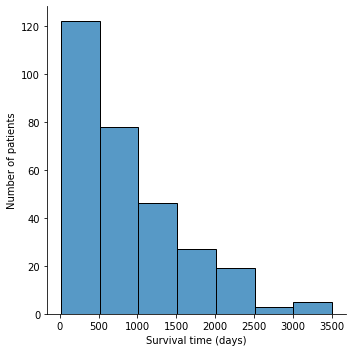

In [ ]:
graph = sns.displot(y_train.SurvivalTime, bins=7)
graph.set_axis_labels("Survival time (days)", "Number of patients")

## **Preprocessing of Test data**

### **Clinical Data**

In [ ]:
clinical_test=pd.read_csv("/content/drive/My Drive/x_test/features/clinical_data_test.csv", index_col='PatientID')
clinical_test.head()

,Histology,Mstage,Nstage,SourceDataset,Tstage,age
PatientID,,,,,,
13,nos,0,0,l1,4,44.3970
155,adenocarcinoma,0,3,l1,1,63.3183
404,large cell,0,2,l1,2,64.7255
407,nos,0,0,l1,2,65.3635
9,Adenocarcinoma,0,0,l2,2,50.0000


In [ ]:
clinical_test.describe()

,Mstage,Nstage,Tstage,age
count,125.00000,125.000000,125.000000,121.000000
mean,0.01600,1.088000,2.264000,67.656020
std,0.12598,1.263737,1.115463,10.030748
min,0.00000,0.000000,1.000000,44.397000
25%,0.00000,0.000000,1.000000,62.000000
50%,0.00000,0.000000,2.000000,68.000000
75%,0.00000,2.000000,3.000000,74.565400
max,1.00000,4.000000,5.000000,91.704300


Variable "age" has 4 missing values

Same preprocessing than for train data is applied to test data

In [ ]:
clinical_test.Mstage.value_counts(sort=False, dropna=False)

0    123
1      2
Name: Mstage, dtype: int64

In [ ]:
clinical_test.Histology.value_counts(sort=False, dropna=False)

NaN                                    12
NSCLC NOS (not otherwise specified)     1
squamous cell carcinoma                23
Adenocarcinoma                         31
Squamous cell carcinoma                 8
adenocarcinoma                          5
large cell                             32
nos                                    13
Name: Histology, dtype: int64

In [ ]:
#Variable "Histology_cat" is created and variables "Histology" and "Mstage" are removed
clinical_test['Histology_cat']=clinical_test.Histology.apply(lambda x: 0 if x in ('Adenocarcinoma','adenocarcinoma') 
                                                              else 1 if x=='large cell' 
                                                              else 2 if x in('squamous cell carcinoma', 'Squamous cell carcinoma') 
                                                              else 3)
clinical_test=clinical_test.drop(columns=['Histology','Mstage'])

In [ ]:
clinical_test.Nstage.value_counts(sort=False, dropna=False)

0    67
1     5
2    30
3    21
4     2
Name: Nstage, dtype: int64

There are 2 patients with Nstage="4". We don't have any in train data. These patients are grouped with Patients Nstage="3".

In [ ]:
clinical_test['Nstage']=clinical_test.Nstage.apply(lambda x: 3 if x==4 else x)

In [ ]:
clinical_test.Tstage.value_counts(sort=False, dropna=False)

1    36
2    48
3    14
4    26
5     1
Name: Tstage, dtype: int64

In [ ]:
#Patient with Tstage="5" is grouped with patients Tstage="4"
clinical_test['Tstage']=clinical_test.Tstage.apply(lambda x: 4 if x==5 else x)

Dummification of categorical variables

In [ ]:
categories = ['Nstage', 'Tstage', 'Histology_cat']
clinical_test = pd.get_dummies(clinical_test, columns=categories, drop_first=True)
clinical_test.head()

,SourceDataset,age,Nstage_1,Nstage_2,Nstage_3,Tstage_2,Tstage_3,Tstage_4,Histology_cat_1,Histology_cat_2,Histology_cat_3
PatientID,,,,,,,,,,,
13,l1,44.3970,0,0,0,0,0,1,0,0,1
155,l1,63.3183,0,0,1,0,0,0,0,0,0
404,l1,64.7255,0,1,0,1,0,0,1,0,0
407,l1,65.3635,0,0,0,1,0,0,0,0,1
9,l2,50.0000,0,0,0,1,0,0,0,0,0


### **Radiomics Features**

In [ ]:
radiomics_test=pd.read_csv("/content/drive/My Drive/x_test/features/radiomics_test.csv", header=1, index_col='PatientID')
radiomics_test.describe()

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_StandardDeviation,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
count,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,1.250000e+02,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.00000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,1.250000e+02,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000
mean,0.025118,0.236966,69.005235,1.703977,0.603505,11108.986749,0.329683,64448.800000,2.907749e+09,4.226877,8.092357,390.088000,-168.757390,161.603665,-125.252000,-928.752000,1318.84000,287.103872,-1.449801,206.162368,0.102372,48657.430068,1144.489010,3.099459e+05,-3244.551250,254.862094,30.387945,0.797380,2.988593,3.180787,0.035119,7.346415,0.480136,0.424026,-0.223524,0.886199,0.989474,0.946058,0.317661,0.097047,64.321826,5.026732,0.846401,2.907961,4862.013570,23698.859346,0.771691,0.004914,1067.592547,0.004454,850.227158,0.008829,3965.904113
std,0.006026,0.109468,35.036927,0.297328,0.097993,11153.620894,0.162203,98583.891199,4.855596e+09,0.879179,10.799861,418.914496,180.759789,81.483656,212.638917,106.909115,449.56781,165.345928,1.506559,78.766371,0.073262,34966.038684,427.709058,3.030280e+05,3733.441944,189.723077,35.129661,0.111750,0.800567,2.019523,0.036712,1.732905,0.150205,0.173989,0.066213,0.074873,0.009559,0.030962,0.083364,0.081833,14.753766,0.929790,0.093618,1.909055,9508.793837,28046.899036,0.137845,0.005647,410.333975,0.005167,286.107130,0.011422,3573.480388
min,0.013143,0.061374,13.076697,1.209814,0.394452,360.071913,0.072954,452.000000,1.259652e+07,2.050655,1.293948,-3.000000,-648.072748,20.922915,-720.000000,-1024.000000,557.00000,39.459458,-7.534997,33.432846,0.022799,1117.755206,227.082082,2.220841e+02,-18509.288020,4.927457,1.103048,0.411644,1.325351,0.573809,0.001016,3.521774,0.218029,0.142390,-0.351859,0.560480,0.952800,0.875877,0.145020,0.005177,26.233733,2.801383,0.599030,1.150945,17.308783,381.924525,0.470120,0.000589,204.978378,0.000372,187.542820,0.001236,260.520715
25%,0.021155,0.159013,39.673669,1.483791,0.541764,2761.980187,0.195032,6477.000000,5.793611e+08,3.562918,2.186637,142.000000,-276.226664,91.616295,-213.000000,-1006.000000,1048.00000,152.74981

All the variables are complete (no missing data)

**Merge of clinical data and radiomics features**

In [ ]:
x_test_svm=pd.merge(radiomics_test, clinical_test, how='inner', left_index=True, right_index=True, sort=True)

Transformation Pipelines

In [ ]:
# Dummy variables are not going to be transformed and are thus removed temporarily from the dataset.
x_test=x_test_svm.drop(columns=['Nstage_1','Nstage_2','Nstage_3','Tstage_2','Tstage_3','Tstage_4','Histology_cat_1', 'Histology_cat_2','Histology_cat_3'])

#Same transformation as for train data is applied
x_test_ = preprocessor.transform(x_test)

x_test=pd.DataFrame(x_test_, index=x_test.index, columns=x_test.columns)
#Dummy variables are included in a new dataset in order to be merged with the other variables afterward
test=clinical_test.loc[:,['Nstage_1','Nstage_2','Nstage_3','Tstage_2','Tstage_3','Tstage_4','Histology_cat_1', 'Histology_cat_2','Histology_cat_3']]

#Merge of the transformed variables with the dummy variables
x_test=pd.merge(x_test, test, how='inner', left_index=True, right_index=True, sort=True)
x_test=x_test.rename(columns={'SourceDataset':'age','age':'SourceDataset'})
x_test.head()

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_StandardDeviation,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,age,SourceDataset,Nstage_1,Nstage_2,Nstage_3,Tstage_2,Tstage_3,Tstage_4,Histology_cat_1,Histology_cat_2,Histology_cat_3
PatientID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.209013,0.095848,-0.176071,-0.350366,0.244278,-0.732233,0.638021,-0.618436,-0.269864,1.068371,-0.537979,-0.114179,-1.647968,1.065586,-1.774349,-0.276677,-0.039849,1.524620,1.012167,0.956569,-0.954965,0.900319,-1.350629,0.143829,0.667257,1.045632,0.328720,0.385683,0.897053,0.732681,-0.808021,1.096412,-1.012173,-1.025879,0.344993,0.617514,-0.255436,-0.655821,-0.993788,-0.942333,-1.495773,1.170435,0.947198,-0.717360,-0.530787,-0.579981,0.979934,0.635321,-1.340500,0.782764,-1.292899,0.117454,-0.822064,0.984372,1.0,0,0,0,0,0,0,0,1,0
1,-0.698843,-0.764171,0.458854,0.453096,-0.663071,0.080456,-0.524799,-0.126859,-0.114092,-0.295386,-0.186256,-0.355261,0.470528,-0.227828,0.640003,-0.932402,-0.107049,-0.424335,-0.303184,-0.133381,0.299593,-0.311785,1.043119,0.105330,-0.654724,-0.207774,-0.437381,0.607068,-0.203577,-0.450548,0.403658,-0.321995,0.524451,0.512268,-0.441112,0.485368,0.505373,0.482273,0.031531,1.113942,0.987445,-0.220634,-0.277438,0.351521,-0.249764,-0.063467,-0.608896,-0.353246,0.908447,-0.411459,0.911400,-0.189871,0.668384,0.309742,0.0,0,1,0,1,0,0,0,1,0
6,0.941255,0.933171,-0.450042,-0.821339,0.931231,-0.501676,-0.459430,-0.454561,-0.361679,0.046629,-0.401380,0.443322,0.528310,0.001537,0.707793,1.220725,0.120041,-0.415342,0.191904,-0.068872,-0.121594,-0.252441,-0.457411,-0.395420,-0.137876,-0.233934,-0.573365,0.914690,-0.254945,-0.521883,0.089859,-0.184981,0.425188,0.394297,-1.005923,0.921458,0.697779,0.606832,0.000857,0.451088,-0.319273,0.017904,-0.128741,0.170257,-0.455765,-0.426389,-0.461749,-0.234991,-0.619558,-0.250414,-0.787674,-0.171412,-0.062877,-0.501119,0.0,0,1,0,0,0,1,0,0,1
9,-1.332325,-1.247471,-0.202770,1.255324,-1.343403,-0.288652,0.262840,-0.449927,1.255220,0.934318,-0.388558,-0.161893,-3.018574,0.323550,-3.161429,-1.000911,0.087599,2.683592,1.655081,0.450349,-0.860047,0.282000,-2.139688,0.284822,2.002292,0.370976,1.325007,-1.529259,1.396793,1.543833,-0.836568,1.405182,-1.437501,-1.420581,2.125307,-2.218849,-1.030575,-1.255418,-1.629032,-1.084481,-2.537692,1.041688,1.169229,-0.792850,-0.459939,-0.188468,1.230154,1.768742,-1.934154,2.116660,-1.982086,0.570044,-0.957345,-2.021283,1.0,0,0,0,1,0,0,0,0,0
10,-1.447554,-1.325062,1.140469,1.433753,-1.472324